In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

os.chdir('../..')

from src.utils_k import add_type_features
from src.utils_r import generate_validation_set

pd.options.display.max_columns = 9999
pd.options.display.max_rows = 9999

In [2]:
from src.utils_f import duration_feature
from src.utils_r import add_num_skus
import lightgbm as lgbm
import re

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
test_session = pd.read_csv('data/raw/random_submission.csv')
test_tracking = pd.read_csv('data/raw/test_tracking.csv')
all_session = pd.read_csv('data/raw/train_session.csv') 
all_tracking = pd.read_csv('data/raw/train_tracking.csv')

In [5]:
trn_session, trn_tracking, val_session, val_tracking = generate_validation_set(all_session, all_tracking, test_size=0.4)

In [6]:
proc_train = add_type_features(trn_session[['sid']], trn_tracking)
proc_val = add_type_features(val_session[['sid']], val_tracking)
proc_all = add_type_features(all_session[['sid']], all_tracking)
proc_test = add_type_features(test_session, test_tracking)

In [7]:
proc_train = duration_feature(proc_train, trn_tracking)
proc_val = duration_feature(proc_val, val_tracking)
proc_all = duration_feature(proc_all, all_tracking)
proc_test = duration_feature(proc_test, test_tracking)

/anaconda/envs/kaggle/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [59]:
all_tracking.columns

Index(['sid', 'type', 'query', 'nb_query_terms', 'rcount', 'pn', 'facets',
       'products', 'dproducts', 'rh', 'rw', 'device', 'idcar', 'carproducts',
       'sku', 'offerid', 'quantity', 'stype', 'sname', 'ff', 'oidcar',
       'ocarproducts', 'oquery', 'orcount', 'ofacets', 'opn', 'odproducts',
       'oproducts', 'siteid', 'duration', 'type_simplified'],
      dtype='object')

In [86]:
prod_sku = all_tracking.loc[(all_tracking.ocarproducts.notnull()) |
                         (all_tracking.products.notnull()) |
                         (all_tracking.oproducts.notnull()) |
                         (all_tracking.carproducts.notnull())][['ocarproducts', 'products', 'oproducts', 'carproducts']].reset_index(drop=True)

prod_sku['TEMP'] = ''

    

In [103]:
import math
for ix, row in prod_sku.iterrows():
    if row.ocarproducts is str:
        prod_sku.at[ix, 'TEMP'] = row.ocarproducts
    elif row.products is str:
        prod_sku.at[ix, 'TEMP'] = row.products
    elif row.oproducts  is str:
        prod_sku.at[ix, 'TEMP'] = row.oproducts
    elif row.carproducts  is str:
        prod_sku.at[ix, 'TEMP'] = row.carproducts

In [108]:
from collections import defaultdict

In [113]:
prod_sku.columns

Index(['ocarproducts', 'products', 'oproducts', 'carproducts', 'TEMP'], dtype='object')

In [114]:
from ast import literal_eval

In [ ]:
dict_ocar = prod_sku.loc[prod_sku.ocarproducts.notnull()].apply(lambda row: literal_eval(row.ocarproducts), axis=1)

In [ ]:
prod_prod = prod_sku.loc[prod_sku.products.notnull()].apply(lambda row: literal_eval(row.products), axis=1)

In [ ]:
dict_oprod = prod_sku.loc[prod_sku.oproducts.notnull()].apply(lambda row: literal_eval(row.oproducts), axis=1)

In [ ]:
dict_carp = prod_sku.loc[prod_sku.carproducts.notnull()].apply(lambda row: literal_eval(row.carproducts), axis=1)

In [110]:
sku_up = {}
sku_down = {}

row['OCAR_PER'] = np.nan
row['PROD_PER'] = np.nan
row['OPRO_PER'] = np.nan
row['CARP_PER'] = np.nan

for ix, row in prod_sku.iterrows():
    if sku_

KeyboardInterrupt: 

In [105]:
prod_sku.head()

,ocarproducts,products,oproducts,carproducts,TEMP
0,NaN,NaN,NaN,[{'sku': 'JHRfp5ydSvpIOBk7rqeHaep6NPTGBfCKCRdX...,NaN
1,NaN,NaN,NaN,[{'sku': 'V8buGT/FybKwREEFPwo8vup6NPTGBfCKCRdX...,NaN
2,NaN,NaN,NaN,[{'sku': 'Acr3ieqo6rTn9cDfXO5/4up6NPTGBfCKCRdX...,NaN
3,NaN,NaN,NaN,[{'sku': 'MlIOsc6DgaqG/BO9BBfEf+p6NPTGBfCKCRdX...,NaN
4,NaN,NaN,NaN,[{'sku': 'saNdFRsUuhoQGmLKSmkgIOp6NPTGBfCKCRdX...,NaN


In [84]:
prod_sku['COUNT'] = prod_sku['TEMP'].apply(lambda row: len(re.findall(r':', row.TEMP)))

AttributeError: 'float' object has no attribute 'TEMP'

In [75]:
temp.head()

0     True
1     True
2     True
3     True
4    False
dtype: bool

In [68]:
prod_sku.loc[prod_sku.notnull().sum(1)>1].index

Int64Index([], dtype='int64')

In [ ]:
train_buy = pd.merge(all_tracking, all_session, how='left', on='sid')
prod_sku = train_buy.loc[(all_tracking.ocarproducts.notnull()) |
                         (all_tracking.products.notnull()) |
                         (all_tracking.oproducts.notnull()) |
                         (all_tracking.carproducts.notnull())][['sku', 'target']].reset_index()
prod_cat = pd.merge(prod_sku, product, left_on='sku', right_on='product_id')

dict_prod = prod_cat.set_index('product_id').to_dict('index')

level_1 = prod_cat.groupby('category_product_id_level1').count().shape[0]
level_2 = prod_cat.groupby('category_product_id_level2').count().shape[0]
level_3 = prod_cat.groupby('category_product_id_level3').count().shape[0]

level_map_1 = prod_cat.groupby(['category_product_id_level1', 'target']).count().to_dict('index')
level_map_2 = prod_cat.groupby(['category_product_id_level2', 'target']).count().to_dict('index')
level_map_3 = prod_cat.groupby(['category_product_id_level3', 'target']).count().to_dict('index')

product['SCORE_LEVEL_1'] = np.nan
product['SCORE_LEVEL_2'] = np.nan
product['SCORE_LEVEL_3'] = np.nan

for ix, row_prod in tqdm(product.iterrows(), total=len(product)):
    if row_prod.product_id in dict_prod:
        if (dict_prod[row_prod.product_id]['category_product_id_level1'], True) in level_map_1:
            product.at[ix, 'SCORE_LEVEL_1'] = level_map_1[(dict_prod[row_prod.product_id]['category_product_id_level1'], True)]['sku'] * 1.0 / level_1
        if (dict_prod[row_prod.product_id]['category_product_id_level2'], True) in level_map_1:
            product.at[ix, 'SCORE_LEVEL_2'] = level_map_1[(dict_prod[row_prod.product_id]['category_product_id_level2'], True)]['sku'] * 1.0 / level_2
        if (dict_prod[row_prod.product_id]['category_product_id_level3'], True) in level_map_1:
            product.at[ix, 'SCORE_LEVEL_3'] = level_map_1[(dict_prod[row_prod.product_id]['category_product_id_level3'], True)]['sku'] * 1.0 / level_3

In [ ]:
def add_score_category()

In [ ]:
el skud que afecta 

In [ ]:
def add_purchase_count(col_prod='sku'):
    
    prod_type = train_tracking.groupby([col_prod, 'type']).count()[['sid']].to_dict('index')
    prod_sim_type = train_tracking.groupby([col_prod, 'type_simplified']).count()[['sid']].to_dict('index')
    
    product[f'PURCHASE_PRODUCT_{col_prod}'] = 0.0
    product[f'PURCHASE_PRODUCT_CAROUSEL_{col_prod}'] = 0.0
    product[f'PURCHASE_PRODUCT_LP_{col_prod}'] = 0.0
    product[f'PURCHASE_PRODUCT_LR_{col_prod}'] = 0.0
    product[f'PURCHASE_PRODUCT_PA_{col_prod}'] = 0.0
    product[f'PURCHASE_PRODUCT_SHOW_CASE_{col_prod}'] = 0.0
    product[f'PURCHASE_PRODUCT_UNKNOW_ORIGIN_{col_prod}'] = 0.0

    for ix, row in tqdm(product.iterrows(), total=len(product)):
        if (row.product_id, 'PURCHASE_PRODUCT') in prod_sim_type:
            product.at[ix, 'PURCHASE_PRODUCT_{col_prod}'] = prod_sim_type[(row.product_id, 'PURCHASE_PRODUCT')]['sid']

        if (row.product_id, 'PURCHASE_PRODUCT_CAROUSEL') in prod_sim_type:
            product.at[ix, 'PURCHASE_PRODUCT_CAROUSEL_{col_prod}'] = prod_sim_type[(row.product_id, 'PURCHASE_PRODUCT_CAROUSEL')]['sid']

        if (row.product_id, 'PURCHASE_PRODUCT_LP') in prod_sim_type:
            product.at[ix, 'PURCHASE_PRODUCT_LP_{col_prod}'] = prod_sim_type[(row.product_id, 'PURCHASE_PRODUCT_LP')]['sid']

        if (row.product_id, 'PURCHASE_PRODUCT_LR') in prod_sim_type:
            product.at[ix, 'PURCHASE_PRODUCT_LR_{col_prod}'] = prod_sim_type[(row.product_id, 'PURCHASE_PRODUCT_LR')]['sid']

        if (row.product_id, 'PURCHASE_PRODUCT_PA') in prod_sim_type:
            product.at[ix, 'PURCHASE_PRODUCT_PA_{col_prod}'] = prod_sim_type[(row.product_id, 'PURCHASE_PRODUCT_PA')]['sid']

        if (row.product_id, 'PURCHASE_PRODUCT_SHOW_CASE') in prod_sim_type:
            product.at[ix, 'PURCHASE_PRODUCT_SHOW_CASE_{col_prod}'] = prod_sim_type[(row.product_id, 'PURCHASE_PRODUCT_SHOW_CASE')]['sid']

        if (row.product_id, 'PURCHASE_PRODUCT_UNKNOW_ORIGIN') in prod_sim_type:
            product.at[ix, 'PURCHASE_PRODUCT_UNKNOW_ORIGIN_{col_prod}'] = prod_sim_type[(row.product_id, 'PURCHASE_PRODUCT_UNKNOW_ORIGIN')]['sid']

In [8]:
def add_filter_features(df, all_data):
    temp = trn_tracking.loc[trn_tracking.facets.notnull()][['sid', 'facets']]
    temp['n_filter'] = temp.apply(lambda row: np.array(re.findall(r': (.*?)[,|}]', row.facets), dtype=int).sum(), axis=1)  
    temp = temp.groupby('sid').sum().reset_index()
    
    return pd.merge(df, temp, on='sid', how='left')

In [9]:
add_num_skus(proc_train, trn_tracking)
add_num_skus(proc_val, val_tracking)
add_num_skus(proc_all, all_tracking)
add_num_skus(proc_test, test_tracking)

In [45]:
from src.utils_f import purchased_products

In [10]:
proc_train = add_filter_features(proc_train, trn_tracking)
proc_val = add_filter_features(proc_val, val_tracking)
proc_all = add_filter_features(proc_all, all_tracking)
proc_test = add_filter_features(proc_test, test_tracking)

In [46]:
proc_train = purchased_products(proc_train, trn_tracking)
proc_val = purchased_products(proc_val, val_tracking)
proc_all = purchased_products(proc_all, all_tracking)
proc_test = purchased_products(proc_test, test_tracking)

In [47]:
proc_train.head()

,sid,ADD_TO_BASKET_CAROUSEL_type,ADD_TO_BASKET_LP_type,ADD_TO_BASKET_LR_type,ADD_TO_BASKET_PA_type,ADD_TO_BASKET_SHOW_CASE_type,CAROUSEL_type,LIST_PRODUCT_type,PA_type,PRODUCT_CAROUSEL_type,PRODUCT_LP_type,PRODUCT_LR_type,PRODUCT_PA_type,PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_CAROUSEL_type,PURCHASE_PRODUCT_LP_type,PURCHASE_PRODUCT_LR_type,PURCHASE_PRODUCT_PA_type,PURCHASE_PRODUCT_SHOW_CASE_type,PURCHASE_PRODUCT_UNKNOW_ORIGIN_type,SEARCH_type,SHOW_CASE_type,SUM_TYPE_type,ADD_TO_BASKET_sim_type,CAROUSEL_sim_type,LIST_PRODUCT_sim_type,PA_sim_type,PRODUCT_sim_type,PURCHASE_PRODUCT_sim_type,SEARCH_sim_type,SHOW_CASE_sim_type,SUM_TYPE_SIMPLIFIED_sim_type,TOTAL_DURATION,NUM_SKUS,n_filter,PURCHASED_PRODUCTS
0,inxo2lfHOeGgN2ySgzK1hAKyCIt17p+honetBOQH4ICtTR...,0.0,0.0,0.000000,0.0,0.0,0.166667,0.0,0.041667,0.083333,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.000000,24.0,0.000000,0.166667,0.0,0.041667,0.125,0.0,0.666667,0.000000,24.0,7840.041643,3,20.0,NaN
1,4CGnnv6GOcYQp/kxVjcx8nN0u5HgaDaLQkC4xIteZJZ/wK...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.875000,0.000000,8.0,0.000000,0.000000,0.0,0.000000,0.125,0.0,0.875000,0.000000,8.0,288.199209,1,NaN,NaN
2,mh22mbOuRnDwAf2OWcrwwymfbZQ/CO3GQuNMO5NREgRV0t...,0.0,0.0,0.000000,0.0,0.0,0.833333,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.000000,6.0,0.000000,0.833333,0.0,0.000000,0.000,0.0,0.166667,0.000000,6.0,613.506545,0,NaN,NaN
3,K/+O1PWZ2vASLTrjvBFT7e62Vee1YyOxCrpMJNoL6edmuC...,0.0,0.0,0.181818,0.0,0.0,0.363636,0.0,0.090909,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272727,0.090909,11.0,0.181818,0.363636,0.0,0.090909,0.000,0.0,0.272727,0.090909,11.0,217.223808,2,NaN,NaN
4,+8SAgYuptilut4CKRE59ncZFDaF4Y+PX6yJ8g4HaALCxI7...,0.0,0.0,0.000000,0.0,0.0,0.200000,0.6,0.000000,0.000000,0.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,5.0,0.000000,0.200000,0.6,0.000000,0.200,0.0,0.000000,0.000000,5.0,168.220206,1,NaN,NaN


In [48]:
proc_train.shape

(79873, 36)

# Validation

In [49]:
X_train = proc_train.drop('sid', axis=1).reset_index(drop=True)
y_train = trn_session.target.reset_index(drop=True)

X_val = proc_val.drop('sid', axis=1).reset_index(drop=True)
y_val = val_session.target.reset_index(drop=True)

X_test = proc_test.drop('sid', axis=1).reset_index(drop=True)

temp_columns = X_train.columns
X_val = X_val[temp_columns]
X_test = X_test[temp_columns]

In [50]:
X_train.drop('n_filter', inplace=True, axis=1)
X_val.drop('n_filter', inplace=True, axis=1)

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[X_train.columns[:32]])
X_train_sc = scaler.transform(X_train[X_train.columns[:32]])
X_val_sc = scaler.transform(X_val[X_val.columns[:32]])

In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 11).fit(X_train_sc)

X_train_pca = (pca.transform(X_train_sc))
X_val_pca = (pca.transform(X_val_sc))

X_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_train_pca)], axis=1)
X_val = pd.concat([pd.DataFrame(X_val), pd.DataFrame(X_val_pca)], axis=1)

In [57]:
# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 6,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.01,
    'metric': 'binary_logloss',
    'verbose': 1
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=700, verbose_eval=100)

[100]	valid_0's binary_logloss: 0.284376
[200]	valid_0's binary_logloss: 0.278154
[300]	valid_0's binary_logloss: 0.275762
[400]	valid_0's binary_logloss: 0.274586
[500]	valid_0's binary_logloss: 0.274057
[600]	valid_0's binary_logloss: 0.273861
[700]	valid_0's binary_logloss: 0.273799


In [18]:
# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.1,
    'metric': 'binary_logloss',
    'verbose': 1,
    'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_train, label=trn_session.target)
d_valid = lgbm.Dataset(X_val, label=val_session.target)

clf = lgbm.train(params, d_train, valid_sets=[d_valid],
                num_boost_round=70)

[1]	valid_0's binary_logloss: 0.304912
[2]	valid_0's binary_logloss: 0.298446
[3]	valid_0's binary_logloss: 0.293581
[4]	valid_0's binary_logloss: 0.28988
[5]	valid_0's binary_logloss: 0.287032
[6]	valid_0's binary_logloss: 0.284648
[7]	valid_0's binary_logloss: 0.282814
[8]	valid_0's binary_logloss: 0.282046
[9]	valid_0's binary_logloss: 0.280683
[10]	valid_0's binary_logloss: 0.279476
[11]	valid_0's binary_logloss: 0.278594
[12]	valid_0's binary_logloss: 0.278364
[13]	valid_0's binary_logloss: 0.277627
[14]	valid_0's binary_logloss: 0.277114
[15]	valid_0's binary_logloss: 0.276616
[16]	valid_0's binary_logloss: 0.276194
[17]	valid_0's binary_logloss: 0.275836
[18]	valid_0's binary_logloss: 0.275516
[19]	valid_0's binary_logloss: 0.27526
[20]	valid_0's binary_logloss: 0.275095
[21]	valid_0's binary_logloss: 0.275047
[22]	valid_0's binary_logloss: 0.274875
[23]	valid_0's binary_logloss: 0.274775
[24]	valid_0's binary_logloss: 0.27463
[25]	valid_0's binary_logloss: 0.274525
[26]	valid_0

# Model

In [57]:
X_all = proc_all.drop('sid', axis=1).reset_index(drop=True)
y_all = all_session.target.reset_index(drop=True)

X_test = proc_test.drop('sid', axis=1).reset_index(drop=True)
temp_columns = X_all.columns
X_test = X_test[temp_columns]

In [51]:
scaler = StandardScaler()
scaler.fit(X_all)
X_all = scaler.transform(X_all)
X_test = scaler.transform(X_test)

In [52]:
pca = PCA(n_components = 10).fit(X_all)

X_all_pca = pd.DataFrame(pca.transform(X_all))
X_test_pca = pd.DataFrame(pca.transform(X_test))

X_all = pd.concat([pd.DataFrame(X_all), pd.DataFrame(X_all_pca)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(X_test_pca)], axis=1)

In [53]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=20,
                              random_state=0)

clf.fit(X_all, y_all)

pca = PCA(n_components = 31).fit(clf.apply(X_all))

scaler = StandardScaler()
scaler.fit(X_all)
X_train = scaler.transform(X_all)
X_val = scaler.transform(X_test)

X_all_rf = (pca.transform(clf.apply(X_all)))
X_test_rf = (pca.transform(clf.apply(X_test)))

X_all = pd.concat([pd.DataFrame(X_all), pd.DataFrame(X_all_rf)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(X_test_rf)], axis=1)

In [54]:
import lightgbm as lgbm

# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'max_depth' : 7,
    'boosting_type' : 'dart',
    'xgboost_dart_mode': True,
    'learning_rate': 0.1,
    #'metric': 'binary_logloss',
    #'bagging_fraction': 0.5,
}

d_train = lgbm.Dataset(X_all, label=y_all)
#d_valid = lgbm.Dataset(X_val, label=y_val)

clf = lgbm.train(params, d_train,# valid_sets=[d_valid],
                num_boost_round=100)

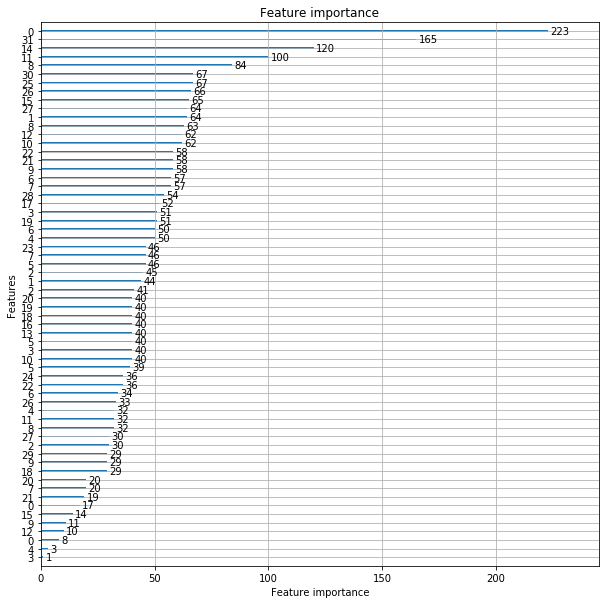

In [55]:
from matplotlib import rcParams
%matplotlib inline 

rcParams['figure.figsize'] = 10, 10
lgbm.plot_importance(clf)

In [56]:
count += 1
preds=clf.predict(X_test)
test_session['target'] = preds
test_session.to_csv(f'data/submissions/kervy_{count}_submit.csv', index=False)

In [21]:
count = 7